## Keyword Clustering (automation of end-to-end process)

### Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import pylab
import math

from datetime import date
from datetime import datetime
import datetime as dt
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from scipy.cluster.hierarchy import fcluster
from matplotlib import pyplot as plt
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats

In [2]:
from rpy2.robjects import r
import rpy2.robjects as robjects

%load_ext rpy2.ipython
%R require("ggplot2")
%R require("scales")
%R require("stringr")
%R require("rpart")
%R require("rpart.plot")

/opt/Envs/DS-Py/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/opt/Envs/DS-Py/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: scales

  warnings.warn(x, RRuntimeWarning)
/opt/Envs/DS-Py/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: stringr

  warnings.warn(x, RRuntimeWarning)
/opt/Envs/DS-Py/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: rpart

  warnings.warn(x, RRuntimeWarning)
/opt/Envs/DS-Py/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: rpart.plot

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
%%R -w 14200 -h 480 -u px
library(ggplot2)

library(rpart)
library(rpart.plot)

### Set the output location

In [4]:
# SET THE OUTPUT LOCATION PATH
output_location = "/home/dsuser/rakhi/SEM/ClusteringProcess/DF/18Nov2015_17Nov2016/"
#output_location = "/home/dsuser/rakhi/SEM/clustering/"

### Data extraction from database

In [5]:
df = pd.read_csv(output_location+'/data_df_18nov2015_to_17nov2016.csv', sep = '\t', header = -1)
df.columns = ['AdGroupId','KeywordId','Date','Keyword','KeywordMatchType','QualityScore','Clicks','AveragePosition','MaxCPC','AverageCPC','Impressions','CTR','Revenue','Orders','ShopperCount','AdGroupIdDup','LatestMaxCPC']
#print df.head()
print df.count()

AdGroupId           2263006
KeywordId           2263006
Date                2263006
Keyword             2263006
KeywordMatchType    2263006
QualityScore        2263006
Clicks              2263006
AveragePosition     2263006
MaxCPC              2263006
AverageCPC          2263006
Impressions         2263006
CTR                 2263006
Revenue                   0
Orders                    0
ShopperCount          77362
AdGroupIdDup        2263006
LatestMaxCPC        2263006
dtype: int64


In [6]:
len(set(df['KeywordId']))

57033

### Step 1: Computing features for each keyword in the given portfolio, using historical search data

In [7]:
# sort data by keyword id & date
df.sort(['KeywordId', 'Date'], ascending = True, inplace = True)

# remove ad group id and de-duplicate on keyword id & date
df_deduplicated = df.drop_duplicates(subset = ['KeywordId', 'Date'], take_last = True)
print df_deduplicated.count()

# replace NA by 0
df_deduplicated.fillna(0, inplace = True)

# basic stats: group by keyword
def span(x):
        _maxdate = datetime.strptime(x.max(),'%Y-%m-%d')
        _mindate = datetime.strptime(x.min(),'%Y-%m-%d')
        _span = abs((_maxdate - _mindate).days)
        return _span

def recency(x):
        _maxdate = datetime.strptime(x.max(),'%Y-%m-%d')
        #_sysdate = dt.datetime.today()
        _sysdate = datetime.strptime('2016-07-12','%Y-%m-%d')
        _recency = abs((_sysdate - _maxdate).days)
        return _recency

def isinlastweek(d):
        #_sysdate = dt.datetime.today()
        _sysdate = datetime.strptime('2016-07-12','%Y-%m-%d')
        return d.apply(lambda x: abs((_sysdate - (datetime.strptime(x,'%Y-%m-%d'))).days) <= 7)

_byKeywordId = df_deduplicated.groupby(['KeywordId'])

_basicstats = _byKeywordId.agg({'Clicks':{'Total_Clicks': np.sum, 'Average_Clicks': np.mean, 'Stddev_Clicks': np.std, 'Median_Clicks': np.median}, 'Impressions':{'Total_Impressions': np.sum, 'Average_Impressions': np.mean,'Stddev_Impressions': np.std, 'Median_Impressions': np.median}, 'Revenue':{'Total_Revenue': np.sum, 'Average_Revenue': np.mean, 'Stddev_Revenue': np.std, 'Median_Revenue': np.median}, 'ShopperCount':{'Total_Shoppers': np.sum, 'Average_Shoppers': np.mean, 'Stddev_Shoppers': np.std, 'Median_Shoppers': np.median}, 'Date':{'Occurrences': len, 'First_Occurrence': np.min, 'Last_Occurrence': np.max, 'Span': span, 'Recency': recency}, 'QualityScore':{'Average_QS': np.mean, 'Median_QS': np.median, 'Min_QS': np.min, 'Max_QS': np.max}})
_basicstats.columns = _basicstats.columns.droplevel(0)

_tempdf = _byKeywordId.apply(lambda x: x[isinlastweek(x['Date'])][['Impressions','Clicks','ShopperCount']].sum())
_tempdf.columns = ['Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers']

_basicstats = _basicstats.join(_tempdf)

_basicstats['Interpurchase_Clicks'] = _basicstats['Span']/_basicstats['Total_Clicks']
_basicstats['Interpurchase_Impressions'] = _basicstats['Span']/_basicstats['Total_Impressions']
_basicstats['Interpurcahse_Shoppers'] = _basicstats['Span']/_basicstats['Total_Shoppers']

_basicstats['Proportion_Clicks'] = _basicstats['Total_Clicks']/sum(_basicstats['Total_Clicks'])
_basicstats['Proportion_Impressions'] = _basicstats['Total_Impressions']/sum(_basicstats['Total_Impressions'])
_basicstats['Proportion_Shoppers'] = _basicstats['Total_Shoppers']/sum(_basicstats['Total_Shoppers'])
_basicstats['Proportion_Revenue'] = _basicstats['Total_Revenue']/sum(_basicstats['Total_Revenue'])

print _basicstats.head()

#_basicstats.to_csv('adgroup_variables_15feb.csv', sep = ',')

/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


AdGroupId           1333868
KeywordId           1333868
Date                1333868
Keyword             1333868
KeywordMatchType    1333868
QualityScore        1333868
Clicks              1333868
AveragePosition     1333868
MaxCPC              1333868
AverageCPC          1333868
Impressions         1333868
CTR                 1333868
Revenue                   0
Orders                    0
ShopperCount          44909
AdGroupIdDup        1333868
LatestMaxCPC        1333868
dtype: int64


/opt/Envs/DS-Py/lib/python2.7/site-packages/pandas/core/frame.py:2705: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


           Total_Revenue  Stddev_Revenue  Median_Revenue  Average_Revenue  \
KeywordId                                                                   
12183261               0               0               0                0   
12183561               0               0               0                0   
12183721               0               0               0                0   
12184051               0               0               0                0   
12184781               0               0               0                0   

           Average_Shoppers  Median_Shoppers  Stddev_Shoppers  Total_Shoppers  \
KeywordId                                                                       
12183261           0.018182                0         0.134840               1   
12183561           0.004405                0         0.066372               1   
12183721           0.000000                0         0.000000               0   
12184051           0.047847                0         0.

In [8]:
len(set(_basicstats.reset_index()['KeywordId']))

57033

### Step 2: K-means clustering

In [9]:
# SET THE NUMBER OF CLUSTERS

K = 10 #10 for IF #2 for RLSA #5 for BUS

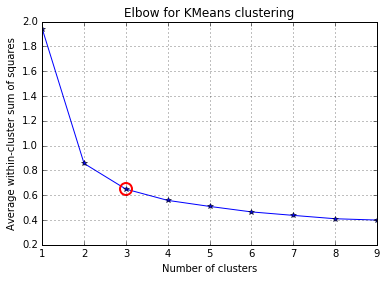

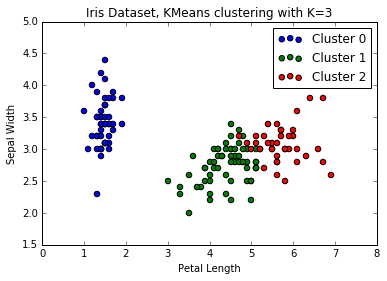

In [10]:
# Trying Elbow Method on Iris Dataset
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# load the iris dataset
fName = '/home/dsuser/rakhi/SEM/ClusteringProcess/iris_input.txt'
fp = open(fName)
X = np.loadtxt(fp,delimiter=",")
fp.close()

##### cluster data into K=1..10 clusters #####
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.cluster.vq.vq
#Z = [vq(X,cent) for cent in centroids]
#avgWithinSS = [sum(dist)/X.shape[0] for (cIdx,dist) in Z]

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X[ind,2],X[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset, KMeans clustering with K=%d' % K[kIdx])
plt.legend()

plt.show()

In [59]:

data = _basicstats.as_matrix(['Median_Shoppers','Recency','Span','Occurrences','Median_Impressions','Median_Clicks','Median_QS','Lastweek_Impressions',
                     'Lastweek_Clicks','Lastweek_Shoppers']) 
all_variables = ['Median_Shoppers','Recency','Span','Occurrences','Median_Impressions','Median_Clicks','Median_QS','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers']

# computing K-Means 
#centroids,_ = kmeans(data,K)
centroids,_ = kmeans(data,8)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

#comment above code for elbow method

#idx,_ = vq(X,centroids[kIdx])
idx,_ = vq(data,centroids)

_basicstats['cluster'] = idx

# Get cluster distribution
all_dict_recs = []
req_vars = ['Average_Shoppers','Median_Shoppers','Stddev_Shoppers','Total_Shoppers','Recency','Span','Occurrences',
            'Total_Impressions','Average_Impressions','Stddev_Impressions','Median_Impressions','Stddev_Clicks',
            'Median_Clicks','Average_Clicks','Total_Clicks','Average_QS','Max_QS','Median_QS','Min_QS','Lastweek_Impressions',
            'Lastweek_Clicks','Lastweek_Shoppers','Interpurchase_Clicks','Interpurchase_Impressions','Interpurcahse_Shoppers']
for i in set(idx):
    _df = _basicstats[idx==i]
    print i, len(_df)
    arr_dict=dict([(j, np.average(_df[j])) for j in req_vars])
    arr_dict['cluster_no'] = i
    arr_dict['length'] = len(_df)
    all_dict_recs.append(arr_dict)
    #print(all_dict_recs)
    
# Compute aggregate features for each cluster
all_dict_recs = []
add_vars = ['Proportion_Clicks','Proportion_Impressions','Proportion_Shoppers','Proportion_Revenue']
idx = _basicstats['cluster'] 
for i in set(idx):
    _df = _basicstats[idx==i]
    arr_dict=dict([(j, np.average(_df[j])) for j in req_vars])
    arr_dict.update([(k, np.sum(_df[k])) for k in add_vars])
    arr_dict['Cluster_No'] = i
    arr_dict['Length'] = len(_df)
    all_dict_recs.append(arr_dict)
    print(all_dict_recs)

0 10492
1 4716
2 6796
3 2
4 10600
5 18114
6 6222
7 91
[{'Max_QS': 8.6341021730842549, 'Span': 12.14735036218071, 'Proportion_Clicks': 0.0011501368832004001, 'Interpurchase_Impressions': nan, 'Cluster_No': 0, 'Median_Impressions': 1.3277258863896302, 'Lastweek_Shoppers': 0.0, 'Average_Shoppers': 0.0, 'Proportion_Shoppers': 0.0, 'Stddev_Shoppers': nan, 'Proportion_Revenue': nan, 'Stddev_Clicks': nan, 'Median_Clicks': 1.0532310331681281, 'Total_Clicks': 1.95110560426992, 'Total_Shoppers': 0.0, 'Average_QS': 8.5468206055681737, 'Stddev_Impressions': nan, 'Proportion_Impressions': 0.0004989531229952455, 'Total_Impressions': 2.6438238658025162, 'Average_Clicks': 1.0680814487011732, 'Median_Shoppers': 0.0, 'Length': 10492, 'Average_Impressions': 1.3655384597366453, 'Interpurchase_Clicks': 4.2257729167100253, 'Lastweek_Clicks': 0.16412504765535646, 'Lastweek_Impressions': 0.21425848265345024, 'Interpurcahse_Shoppers': nan, 'Median_QS': 8.5548513152878378, 'Min_QS': 8.4446244757910787, 'Recency

### Step 3: Hierarchical clustering on each of the K clusters identified in step 2

In [61]:
# SET THE MAX NUMBER OF SUB-CLUSTERS FOR EACH CLUSTER
max_sc = 4

# SET THE DENDROGRAM CUT-POINT INCREMENT VALUE
cut_pt = 500 #500 for IF #50 for RLSA

# SET THE MAX NUMBER OF ITERATIONS TO DECIDE FINAL CUT-POINT
max_iter = 8

In [62]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [70]:
df[df['cluster']==1][['Median_Shoppers','Recency','Span','Occurrences','Median_Impressions','Median_Clicks',
                        'Median_QS','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers']].to_csv(output_location+'temp.csv',index=False)

In [68]:
df[df['cluster']==1][['Median_Shoppers','Recency','Span','Occurrences','Median_Impressions','Median_Clicks',
                        'Median_QS','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers']].isnull().any()

Median_Shoppers         False
Recency                 False
Span                    False
Occurrences             False
Median_Impressions      False
Median_Clicks           False
Median_QS               False
Lastweek_Impressions    False
Lastweek_Clicks         False
Lastweek_Shoppers       False
dtype: bool

In [85]:
for i in [1,3]:
    faulty_cluster = df[df['cluster']==i]
    faulty_cluster['sub_cluster'] = 0
    faulty_cluster.to_csv(output_location+'/Keywords_Hierarchical_clustering_result_c' + str(i) + '.csv', index=False)

/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [64]:
def level2clustering(i):
    # subset the dataframe for given cluster id
    _df = df[df['cluster']==i]
    
    #if len(_df) > 12000:
        #return
    
    _X = _df.as_matrix(['Median_Shoppers','Recency','Span','Occurrences','Median_Impressions','Median_Clicks',
                        'Median_QS','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers']) 
    
    # generate the linkage matrix
    Z = linkage(_X, 'ward')
    
    # decide on dendrogram cut-point
    for iter in range(0,max_iter-1):
        # set max_distance cut-off to cut the dendrogram
        max_d = cut_pt * (iter + 1)
        #print iter, max_d
        
        # find clusters for given max_distance
        clusters = fcluster(Z, max_d, criterion='distance')

        if len(set(clusters)) <= max_sc:
            break
           
    # plot the dendrogram
    plt.clf()
    fancy_dendrogram(
        Z,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,
        max_d=max_d,  # plot a horizontal cut-off line
    )
    #plt.show()
    #plt.clf()
    plt.savefig(output_location+'/Dendrogram_c'+str(i)+'.png')
    
    # compute Silhouette Coefficient
    with open(output_location+"/SilhouetteCoefficient.txt", "a") as myfile:
        myfile.write("Cluster: " + str(i) + ", => SC: " + str(metrics.silhouette_score(_X, clusters)) + "\n")
    
    # get sub-cluster number
    _df['sub_cluster'] = clusters
    _df.to_csv(output_location+'/Keywords_Hierarchical_clustering_result_c' + str(i) + '.csv', index=False)
    
    # compute aggregate features for each sub-cluster
    all_dict_recs = []
    req_vars = ['Average_Shoppers','Median_Shoppers','Stddev_Shoppers','Total_Shoppers','Recency','Span','Occurrences',
                'Total_Impressions','Average_Impressions','Stddev_Impressions','Median_Impressions','Stddev_Clicks',
                'Median_Clicks','Average_Clicks','Total_Clicks','Average_QS','Max_QS','Median_QS','Min_QS','Lastweek_Impressions',
                'Lastweek_Clicks','Lastweek_Shoppers','Interpurchase_Clicks','Interpurchase_Impressions','Interpurcahse_Shoppers']

    add_vars = ['Proportion_Clicks','Proportion_Impressions','Proportion_Shoppers','Proportion_Revenue']

    scidx = _df['sub_cluster'] # for temp file 
    for sc in set(scidx):
        __df = _df[scidx==sc]
        arr_dict=dict([(j, np.average(__df[j])) for j in req_vars])
        arr_dict.update([(k, np.sum(__df[k])) for k in add_vars])
        arr_dict['Sub_Cluster_No'] = sc
        arr_dict['Sub_Cluster_Length'] = len(__df)
        arr_dict['Cluster_No'] = i
        arr_dict['Cluster_Length'] = len(_df)
        all_dict_recs.append(arr_dict)
        #print(all_dict_recs)
    
    pd.DataFrame.from_dict(all_dict_recs).to_csv(output_location+'/Keywords_Hierarchical_clustering_summary_c' + str(i) + '.csv', index=False)   

In [65]:
_basicstats.reset_index().columns

Index([u'KeywordId', u'Total_Revenue', u'Stddev_Revenue', u'Median_Revenue',
       u'Average_Revenue', u'Average_Shoppers', u'Median_Shoppers',
       u'Stddev_Shoppers', u'Total_Shoppers', u'Recency', u'Span',
       u'Occurrences', u'First_Occurrence', u'Last_Occurrence',
       u'Total_Impressions', u'Average_Impressions', u'Stddev_Impressions',
       u'Median_Impressions', u'Stddev_Clicks', u'Median_Clicks',
       u'Average_Clicks', u'Total_Clicks', u'Average_QS', u'Max_QS',
       u'Median_QS', u'Min_QS', u'Lastweek_Impressions', u'Lastweek_Clicks',
       u'Lastweek_Shoppers', u'Interpurchase_Clicks',
       u'Interpurchase_Impressions', u'Interpurcahse_Shoppers',
       u'Proportion_Clicks', u'Proportion_Impressions', u'Proportion_Shoppers',
       u'Proportion_Revenue', u'cluster'],
      dtype='object')

In [66]:
len(_basicstats)

57033

/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


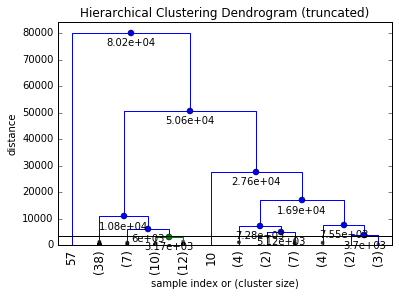

In [72]:
df = _basicstats.reset_index()
idx = df['cluster']
#for i in set(idx):
for i in [0,2,4,5,6,7]: #HACK: skipping few clusters
    level2clustering(i)

### Step 4: (Cluster, Sub-cluster) mapping to (Keyword sets)

In [86]:
os.system("cat "+output_location+"/Keywords_Hierarchical_clustering_result_c* | grep -v Proportion >"+output_location+"/Keywords_Hierarchical_clustering_result_merged.csv")

0

In [87]:
resultdf = pd.read_csv(output_location+'/Keywords_Hierarchical_clustering_result_merged.csv', sep = ',',header=None)
#resultdf.columns = ['Unnamed: 0','KeywordId','Total_Revenue','Stddev_Revenue','Median_Revenue','Average_Revenue','Average_Shoppers','Median_Shoppers','Stddev_Shoppers','Total_Shoppers','Recency','Span','Occurrences','First_Occurrence','Last_Occurrence','Total_Impressions','Average_Impressions','Stddev_Impressions','Median_Impressions','Stddev_Clicks','Median_Clicks','Average_Clicks','Total_Clicks','Average_QS','Max_QS','Median_QS','Min_QS','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers','Interpurchase_Clicks','Interpurchase_Impressions','Interpurcahse_Shoppers','Proportion_Clicks','Proportion_Impressions','Proportion_Shoppers','Proportion_Revenue','KeywordDesc','MatchType','cluster','sub_cluster']
resultdf.columns = ['KeywordId','Total_Revenue','Stddev_Revenue','Median_Revenue','Average_Revenue','Average_Shoppers','Median_Shoppers','Stddev_Shoppers','Total_Shoppers','Recency','Span','Occurrences','First_Occurrence','Last_Occurrence','Total_Impressions','Average_Impressions','Stddev_Impressions','Median_Impressions','Stddev_Clicks','Median_Clicks','Average_Clicks','Total_Clicks','Average_QS','Max_QS','Median_QS','Min_QS','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers','Interpurchase_Clicks','Interpurchase_Impressions','Interpurcahse_Shoppers','Proportion_Clicks','Proportion_Impressions','Proportion_Shoppers','Proportion_Revenue','cluster','sub_cluster']

def genTag(x):
    return str(x['cluster'])+"_"+str(x['sub_cluster'])

resultdf['tag'] = resultdf.apply(lambda x: genTag(x), axis = 1)

In [88]:
_resultdf = resultdf[['KeywordId','Proportion_Clicks','Proportion_Impressions','Proportion_Shoppers','tag']]
_resultdf['Proportion_Clicks'] = _resultdf['Proportion_Clicks'].astype(float)
_resultdf['Proportion_Impressions'] = _resultdf['Proportion_Impressions'].astype(float)
_resultdf['Proportion_Shoppers'] = _resultdf['Proportion_Shoppers'].astype(float)

__resultdf_tag = _resultdf.groupby(['tag']).agg({'KeywordId':{'No_of_Keywords':'nunique'},
                                                 'Proportion_Clicks':{'Proportion_Clicks':'sum'},
                                                 'Proportion_Impressions':{'Proportion_Impressions':'sum'},
                                                 'Proportion_Shoppers':{'Proportion_Shoppers':'sum'}})
__resultdf_tag.columns = __resultdf_tag.columns.droplevel(0)
__resultdf_tag

#'AdGroupId':{'No_of_Adgroups':'nunique'},

/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,Proportion_Shoppers,No_of_Keywords,Proportion_Clicks,Proportion_Impressions
tag,,,,
0_1,0.000000,6070,0.000604,0.000262
0_2,0.000000,4422,0.000546,0.000237
1_0,0.003561,4716,0.001283,0.001331
2_1,0.007530,2624,0.002051,0.001551
2_2,0.003537,1776,0.000952,0.000828
2_3,0.000000,1012,0.000609,0.000560
2_4,0.000008,1384,0.000684,0.000409
3_0,0.644473,2,0.725103,0.560456
4_1,0.000000,1234,0.000726,0.000403


In [89]:
#_result_sorted = __resultdf_tag.sort(['Proportion_Impressions', 'Proportion_Clicks'], ascending=[0, 0])

__resultdf_tag['Avg_C'] = __resultdf_tag['Proportion_Clicks']/__resultdf_tag['No_of_Keywords']
_result_sorted = __resultdf_tag.sort(['Avg_C'], ascending=[0])
_result_sorted.head()

/opt/Envs/DS-Py/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Proportion_Shoppers,No_of_Keywords,Proportion_Clicks,Proportion_Impressions,Avg_C
tag,,,,,
3_0,0.644473,2,0.725103,0.560456,0.362552
7_11,0.000740,1,0.012044,0.008543,0.012044
7_7,0.027617,4,0.030285,0.020636,0.007571
7_8,0.003019,2,0.008416,0.014057,0.004208
7_10,0.003399,1,0.004185,0.011959,0.004185


In [127]:
A_c_threshold = 0.95 #0.90 bus #0.35 #0.85 for IF #0.7 for RLSA
A_i_threshold = 0.96 #0.95 bus #0.45 #0.95 for IF #0.8 for RLSA
B_c_threshold = 0.97 #0.95 bus #0.37 #0.95 for IF #0.8 for RLSA
B_i_threshold = 0.98 #0.99 bus #0.47 #0.98 for IF #0.9 for RLSA

cum_prop_impr = 0.0
cum_prop_clk = 0.0
cur_class = 'A'

_class_dict = dict()

for index, row in _result_sorted.iterrows():
    cum_prop_impr = cum_prop_impr + row['Proportion_Impressions']
    cum_prop_clk = cum_prop_clk + row['Proportion_Clicks']
    _class_dict[index] = cur_class
    if (cum_prop_impr >= A_i_threshold) | (cum_prop_clk >= A_c_threshold):
        cur_class = 'B'
    if (cum_prop_impr >= B_i_threshold) | (cum_prop_clk >= B_c_threshold):
        cur_class = 'C'

_class_dict

{'0_1': 'C',
 '0_2': 'C',
 '1_0': 'C',
 '2_1': 'C',
 '2_2': 'C',
 '2_3': 'C',
 '2_4': 'C',
 '3_0': 'A',
 '4_1': 'C',
 '4_2': 'C',
 '4_3': 'C',
 '4_4': 'C',
 '5_1': 'A',
 '5_2': 'A',
 '5_3': 'A',
 '5_4': 'A',
 '5_5': 'B',
 '5_6': 'A',
 '5_7': 'A',
 '6_1': 'C',
 '6_2': 'C',
 '6_3': 'C',
 '6_4': 'C',
 '7_1': 'A',
 '7_10': 'A',
 '7_11': 'A',
 '7_2': 'A',
 '7_3': 'A',
 '7_4': 'A',
 '7_5': 'A',
 '7_6': 'A',
 '7_7': 'A',
 '7_8': 'A',
 '7_9': 'A'}

In [128]:
def genTargetClass(x):
    return _class_dict[x['tag']]

resultdf['target_class'] = resultdf.apply(lambda x: genTargetClass(x), axis = 1)

resultdf.to_csv(output_location+'/Keywords_target_class.csv', index=False)
resultdf.head()
resultdf['target_class'].value_counts()

C    38826
B    11380
A     6827
Name: target_class, dtype: int64

### Step 5: Discretization of continuous independent variables

In [129]:
# equal frequency binning
def defineBinsEF(field):
    nobs = len(field)
    nbins = 3 # np.floor(np.sqrt(nobs))
    bins = np.ceil(nbins * stats.rankdata(field)/nobs)
    getBinBoundaries(field,bins)
    return bins

def getBinBoundaries(idata,bins):
    for i in set(bins):
        ifmatch = np.where(bins==i,1,0)
        sdata = idata * ifmatch
        if(sum(sdata)==0):
            print "Bin " + str(int(i)) + ": [0,0]"
        else:
            print "Bin " + str(int(i)) + ": [" + str(min(sdata[sdata != 0])) + "," + str(max(sdata[sdata != 0])) + "]"

# equal width binning
def defineBinsEW(min,max):
    print min, max
    bin_width = (max - min)/4
    bins = [min]
    for i in range(0,4):
        last_element = bins[len(bins)-1]
        bins.extend([last_element + bin_width])
    #print bins
    return bins

def defineBinNames(feature,bins):
    group_names = []
    for i in range(0,len(bins)-1):
        if(bins[i] < 0.0009):
            group_names.extend(['('+ str("{:.2E}".format(bins[i])) + ',' + str("{:.2E}".format(bins[i+1])) + ')'])
        else:
            group_names.extend(['('+ str(bins[i]) + ',' + str(bins[i+1]) + ')'])
    #print group_names
    return group_names
    
def getBins(field, bins, group_names):
    categories = pd.cut(field, bins, labels=group_names, include_lowest = True, right = True)
    return categories

def categorize(field,feature,bintype):
    if bintype == "ew":
        bins = defineBinsEW(min(field),max(field))
        group_names = defineBinNames(feature,bins)
        resultdf[feature+'_C'] = getBins(field, bins, group_names)
        #print pd.value_counts(getBins(field, bins, group_names))
    if bintype == "ef":
        resultdf[feature+'_C'] = defineBinsEF(field)

def toTransform(field,feature,bintype):
    features_to_be_transformed = ['Span','Proportion_Impressions','Lastweek_Impressions','Lastweek_Clicks','Lastweek_Shoppers',
                                  'Proportion_Clicks','Proportion_Shoppers','Occurrences','Median_Impressions','Median_Clicks',
                                  'Median_Shoppers','Recency']
    if feature in features_to_be_transformed:
        print "\n" + feature
        categorize(field,feature,bintype)

bintype = "ef"
resultdf.apply(lambda column: toTransform(column, column.__dict__['name'],bintype), axis = 0)

print ''


Median_Shoppers
Bin 2: [0,0]
Bin 3: [0.5,2.0]

Recency
Bin 1: [1,65]
Bin 2: [66,114]
Bin 3: [115,236]

Span
Bin 1: [1,115]
Bin 2: [116,292]
Bin 3: [293,363]

Occurrences
Bin 1: [1,3]
Bin 2: [4,14]
Bin 3: [15,357]

Median_Impressions
Bin 1: [0.5,1.0]
Bin 2: [1.5,1.5]
Bin 3: [2.0,62186.0]

Median_Clicks
Bin 2: [1.0,1.0]
Bin 3: [1.5,26448.0]

Lastweek_Impressions
Bin 1: [0,0]
Bin 2: [1.0,1.0]
Bin 3: [2.0,822122.0]

Lastweek_Clicks
Bin 1: [0,0]
Bin 3: [1.0,351969.0]

Lastweek_Shoppers
Bin 2: [0,0]

Proportion_Clicks
Bin 1: [5.61837176103e-08,1.68551152831e-07]
Bin 2: [2.24734870441e-07,8.98939481765e-07]
Bin 3: [9.55123199375e-07,0.513046561526]

Proportion_Impressions
Bin 1: [1.79874228702e-08,7.19496914806e-08]
Bin 2: [8.99371143508e-08,4.67672994624e-07]
Bin 3: [4.85660417494e-07,0.387340822325]

Proportion_Shoppers
Bin 2: [0,0]
Bin 3: [2.61647910872e-06,0.448166240617]



### Step 6: Training decision tree

In [130]:
# SET THE DEPTH OF THE DECISION TREE

%R mdepth <- 30

array([ 30.])

In [131]:
#result_r = resultdf[['Proportion_Impressions_C','Lastweek_Impressions_C','Lastweek_Clicks_C','Lastweek_Shoppers_C',
#                     'Proportion_Clicks_C','Proportion_Shoppers_C','Occurrences_C','Median_Impressions_C','Median_Clicks_C',
#                     'Median_Shoppers_C','Recency_C','sub_cluster','cluster','tag','target_class']]

result_r = resultdf[['Span_C','Lastweek_Impressions_C','Lastweek_Clicks_C','Lastweek_Shoppers_C',
                     'Occurrences_C','Median_Impressions_C','Median_Clicks_C',
                     'Median_Shoppers_C','Recency_C','sub_cluster','cluster','tag','target_class']]

%Rpush result_r

In [136]:
%%R 
result_r[] <- lapply(result_r,factor)
rc <- rpart.control(minsplit = 50, cp = 0.01, maxcompete = 4, maxsurrogate = 5, usesurrogate = 2, xval = 10,surrogatestyle = 0, maxdepth = mdepth)

fit <- rpart(target_class ~ + Span_C + Lastweek_Impressions_C + Lastweek_Clicks_C + 
             Lastweek_Shoppers_C + Occurrences_C + Median_Impressions_C + 
             Median_Clicks_C + Median_Shoppers_C , method="class", data=result_r, control=rc) # + Recency_C

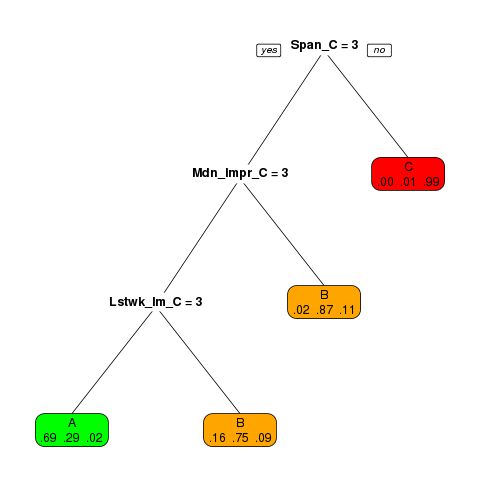

In [137]:
%%R
par(xpd=TRUE)
prp(fit, 
    type = 0, 
    extra = 4, 
    branch = 0, 
    uniform = TRUE, 
    Margin = 0.0,
    gap = 1,
    varlen = 10,
    faclen = 0, 
    cex = 0.8, 
    tweak = 1.3, 
    ycompress = FALSE,
    compress = TRUE,
    box.col=c("green", "orange","red")[fit$frame$yval])
    #box.col=0)

### Step 7: Performance evaluation (confusion matrix, recall, precision, f1-score)

In [138]:
# IDENTIFY THE TARGET VARIABLE

%R tag <- result_r$target_class

[C, C, C, C, C, ..., A, A, A, A, A]
Length: 57033
Categories (3, object): [A, B, C]

In [139]:
%%R
pred <- predict(fit,type="class")
confusion_matrix <- table(pred,tag)
cat("CONFUSION MATRIX")
print(confusion_matrix)

total_data_points <- sum(confusion_matrix)
true_positive <- sum(diag(confusion_matrix))
true_positive_rate <- true_positive/total_data_points
cat(paste('\nTOTAL DATA POINTS:',total_data_points,'\nTRUE POSITIVES:',true_positive,'\nTRUE POSITIVE RATE:',true_positive_rate))

recall_each_class <- diag(confusion_matrix)/apply(confusion_matrix, 2, sum)
cat('\n\nRECALL\n')
print(recall_each_class)

precision_each_class <- diag(confusion_matrix)/apply(confusion_matrix, 1, sum)
cat('\nPRECISION\n')
print(precision_each_class)

f1score_each_class <- 2 * (recall_each_class * precision_each_class) / (recall_each_class + precision_each_class)
cat('\nF1 SCORE\n')
print(f1score_each_class)

CONFUSION MATRIX    tag
pred     A     B     C
   A  6057  2505   177
   B   609  8549  1091
   C   161   326 37558

TOTAL DATA POINTS: 57033 
TRUE POSITIVES: 52164 
TRUE POSITIVE RATE: 0.914628373047183

RECALL
        A         B         C 
0.8872125 0.7512302 0.9673415 

PRECISION
        A         B         C 
0.6930999 0.8341302 0.9871994 

F1 SCORE
        A         B         C 
0.7782346 0.7905127 0.9771695 
